In [5]:
# First load in train, valid, and test datasets
import pandas as pd
import numpy as np

import itertools

from data_handling.bert_data_tokenization import get_dataset_for_category_bert
from data_handling.data import DocumentData, BinaryCUADDataset
from metrics.metrics import get_metrics, calculate_metrics, calculate_chunk_accuracy, calculate_document_accuracy, calculate_soft_document_accuracy
from utils.bert_utils import train_bert
from utils.utils import get_device

import matplotlib.pyplot as plt
import pandas as pd
import torch

import os
import json
import math
import random
from tqdm import tqdm

# Models

import torch.nn as nn
from torch.utils.data import DataLoader

# Training

import torch.optim as optim
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, AdamW
from transformers import BertTokenizerFast, BertForSequenceClassification

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# INFO

This file is able to run both the BERT and the RoBERTa models, you only have to change the model name.

The two model names that I've used are:

* roberta-base
* bert-base-uncased

In [9]:
def run_with_categories(categories, model_name):
    for category in categories:
        run(category, model_name)
        
def run(category, model_name):
    data_source = "data/CUADv1.json"
    num_examples = 255 # 510 is max
    subpart_size = 512
    subpart_overlap = 26
    data_destination = f"data/binary_dataset_{model_name}_{subpart_size}_{subpart_overlap}_{num_examples}.json"
    vocab_destination = f"data/vocab_{model_name}_{num_examples}.json"
    category = category

    model_name = model_name
    
    
    if model_name == "roberta-base":
        tokenize = RobertaTokenizerFast.from_pretrained(model_name)
    else:
        tokenize = BertTokenizerFast.from_pretrained(model_name)

    train_dataset, test_dataset, tokenize = get_dataset_for_category_bert(category, data_source, data_destination, vocab_destination, num_examples, subpart_size, subpart_overlap, tokenize)
    
    train_loader = DataLoader(train_dataset, shuffle=True)
    test_loader = DataLoader(test_dataset, shuffle=True)

    device = get_device()

    # Declare the model
    if model_name == "roberta-base":
        model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=1, num_hidden_layers=8).to(device)
    else:
        model = BertForSequenceClassification.from_pretrained(model_name, num_labels=1, num_hidden_layers=8).to(device)

    optimizer = AdamW(model.parameters(), lr = 8e-6,)
    
    train_bert(model, optimizer, train_loader, test_loader, category, model_name, device=device, num_epochs=5)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Creating subparts and labels:   1%|          | 2/255 [00:00<00:17, 14.84it/s]

255
No existing file with same configuration, creating new file....


Creating subparts and labels: 100%|██████████| 255/255 [00:13<00:00, 18.98it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Ratio: 0.7
Pos train: 208
Neg train: 47
Batch size: 18
Randomizing training and testing data..


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.encoder.layer.9.attention.self.value.bias', 'roberta.encoder.layer.11.attention.output.dense.bias', 'roberta.encoder.layer.8.attention.self.value.bias', 'roberta.encoder.layer.8.output.dense.bias', 'roberta.encoder.layer.8.attention.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.value.bias', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.9.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.output.LayerNorm.bias', 'roberta.encoder.layer.8.attention.self.query.weight', 'roberta.encoder.layer.10.intermediate.dense.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'roberta.encoder.layer.10.attention.output.dense.weight', 'roberta.encoder.layer.11.output.LayerNorm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bi



Training (0/5): {'precision': 0.8678439191113643, 'recall': 0.919155354449472, 'f1': 0.8927629651333137, 'tp': 3047, 'tn': 811, 'fp': 464, 'fn': 268} Loss: 0.35027

---------- EVALUATION ----------
Document Accuracy: 0.1667
Soft Document Accuracy: 0.9683
Chunk Accuracy: 0.9133
Loss: 0.5014909385488584
precision: 0.26296296296296295
recall: 0.9466666666666667
f1: 0.4115942028985507
tp: 71
tn: 2067
fp: 199
fn: 4


Training Epochs:  20%|██        | 1/5 [02:42<10:49, 162.27s/it]



Training (1/5): {'precision': 0.9905775075987842, 'recall': 0.9831070889894419, 'f1': 0.9868281604844815, 'tp': 3259, 'tn': 1244, 'fp': 31, 'fn': 56} Loss: 0.07508

---------- EVALUATION ----------
Document Accuracy: 0.3333
Soft Document Accuracy: 0.9683
Chunk Accuracy: 0.9449
Loss: 0.33954051519051576
precision: 0.36082474226804123
recall: 0.9333333333333333
f1: 0.5204460966542751
tp: 70
tn: 2142
fp: 124
fn: 5


Training Epochs:  40%|████      | 2/5 [05:28<08:14, 164.68s/it]



Training (2/5): {'precision': 0.9948531637904935, 'recall': 0.9912518853695325, 'f1': 0.9930492595950438, 'tp': 3286, 'tn': 1258, 'fp': 17, 'fn': 29} Loss: 0.03136

---------- EVALUATION ----------
Document Accuracy: 0.2051
Soft Document Accuracy: 0.9683
Chunk Accuracy: 0.9342
Loss: 0.45388602991051114
precision: 0.319634703196347
recall: 0.9333333333333333
f1: 0.4761904761904762
tp: 70
tn: 2117
fp: 149
fn: 5


Training Epochs:  60%|██████    | 3/5 [08:14<05:30, 165.30s/it]



Training (3/5): {'precision': 0.9972801450589301, 'recall': 0.995475113122172, 'f1': 0.9963768115942029, 'tp': 3300, 'tn': 1266, 'fp': 9, 'fn': 15} Loss: 0.01705

---------- EVALUATION ----------
Document Accuracy: 0.3333
Soft Document Accuracy: 0.9683
Chunk Accuracy: 0.9466
Loss: 0.3675335036883226
precision: 0.3684210526315789
recall: 0.9333333333333333
f1: 0.5283018867924527
tp: 70
tn: 2146
fp: 120
fn: 5


Training Epochs:  80%|████████  | 4/5 [11:00<02:45, 165.40s/it]



Training (4/5): {'precision': 0.9987900786448881, 'recall': 0.996078431372549, 'f1': 0.9974324120223532, 'tp': 3302, 'tn': 1271, 'fp': 4, 'fn': 13} Loss: 0.00985

---------- EVALUATION ----------
Document Accuracy: 0.2949
Soft Document Accuracy: 0.9683
Chunk Accuracy: 0.9449
Loss: 0.468054649667092
precision: 0.36082474226804123
recall: 0.9333333333333333
f1: 0.5204460966542751
tp: 70
tn: 2142
fp: 124
fn: 5


Training Epochs: 100%|██████████| 5/5 [13:45<00:00, 165.17s/it]

Finished Training!


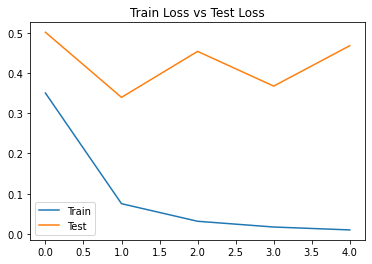

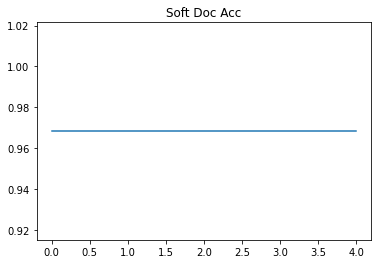

Creating vocabulary: 100%|██████████| 255/255 [00:08<00:00, 30.69it/s]


255
Found existing file, loading....
Finished loading file
Ratio: 0.7
Pos train: 189
Neg train: 66
Batch size: 19
Randomizing training and testing data..


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.encoder.layer.9.attention.self.value.bias', 'roberta.encoder.layer.11.attention.output.dense.bias', 'roberta.encoder.layer.8.attention.self.value.bias', 'roberta.encoder.layer.8.output.dense.bias', 'roberta.encoder.layer.8.attention.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.value.bias', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.9.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.output.LayerNorm.bias', 'roberta.encoder.layer.8.attention.self.query.weight', 'roberta.encoder.layer.10.intermediate.dense.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'roberta.encoder.layer.10.attention.output.dense.weight', 'roberta.encoder.layer.11.output.LayerNorm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bi



Training (0/5): {'precision': 0.8327611574301128, 'recall': 0.9512605042016806, 'f1': 0.8880753138075314, 'tp': 3396, 'tn': 593, 'fp': 682, 'fn': 174} Loss: 0.40817

---------- EVALUATION ----------
Document Accuracy: 0.039
Soft Document Accuracy: 0.9825
Chunk Accuracy: 0.7332
Loss: 0.9119151238497202
precision: 0.12310030395136778
recall: 0.9310344827586207
f1: 0.21744966442953023
tp: 81
tn: 1521
fp: 577
fn: 6


Training Epochs:  20%|██        | 1/5 [02:50<11:21, 170.33s/it]



Training (1/5): {'precision': 0.9668416689693285, 'recall': 0.9801120448179271, 'f1': 0.9734316316594797, 'tp': 3499, 'tn': 1155, 'fp': 120, 'fn': 71} Loss: 0.12283

---------- EVALUATION ----------
Document Accuracy: 0.4545
Soft Document Accuracy: 0.9298
Chunk Accuracy: 0.9716
Loss: 0.1875867933796888
precision: 0.6033057851239669
recall: 0.8390804597701149
f1: 0.7019230769230769
tp: 73
tn: 2050
fp: 48
fn: 14


Training Epochs:  40%|████      | 2/5 [05:42<08:33, 171.18s/it]



Training (2/5): {'precision': 0.9930245535714286, 'recall': 0.9969187675070028, 'f1': 0.9949678501537602, 'tp': 3559, 'tn': 1250, 'fp': 25, 'fn': 11} Loss: 0.02786

---------- EVALUATION ----------
Document Accuracy: 0.3117
Soft Document Accuracy: 0.9474
Chunk Accuracy: 0.9387
Loss: 0.2599549922039853
precision: 0.38308457711442784
recall: 0.8850574712643678
f1: 0.5347222222222222
tp: 77
tn: 1974
fp: 124
fn: 10


Training Epochs:  60%|██████    | 3/5 [08:34<05:43, 171.61s/it]



Training (3/5): {'precision': 0.9980408620207109, 'recall': 0.9988795518207283, 'f1': 0.998460030799384, 'tp': 3566, 'tn': 1268, 'fp': 7, 'fn': 4} Loss: 0.00856

---------- EVALUATION ----------
Document Accuracy: 0.4935
Soft Document Accuracy: 0.9298
Chunk Accuracy: 0.9698
Loss: 0.178869480563497
precision: 0.5826771653543307
recall: 0.8505747126436781
f1: 0.6915887850467289
tp: 74
tn: 2045
fp: 53
fn: 13


Training Epochs:  80%|████████  | 4/5 [11:26<02:52, 172.01s/it]



Training (4/5): {'precision': 0.9997199663959675, 'recall': 1.0, 'f1': 0.9998599635905335, 'tp': 3570, 'tn': 1274, 'fp': 1, 'fn': 0} Loss: 0.00269

---------- EVALUATION ----------
Document Accuracy: 0.5195
Soft Document Accuracy: 0.9298
Chunk Accuracy: 0.9744
Loss: 0.171146362258708
precision: 0.6324786324786325
recall: 0.8505747126436781
f1: 0.7254901960784313
tp: 74
tn: 2055
fp: 43
fn: 13


Training Epochs: 100%|██████████| 5/5 [14:22<00:00, 172.50s/it]

Finished Training!


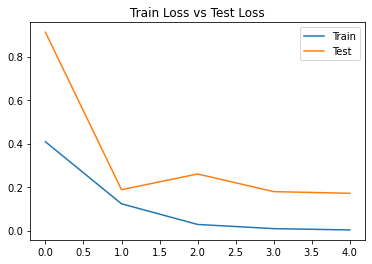

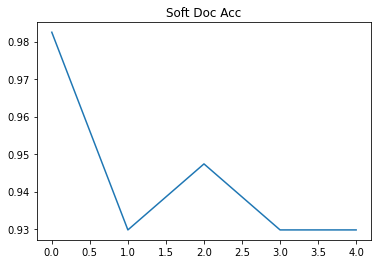

Creating vocabulary: 100%|██████████| 255/255 [00:08<00:00, 31.08it/s]


255
Found existing file, loading....
Finished loading file
Ratio: 0.5
Pos train: 135
Neg train: 120
Batch size: 19
Randomizing training and testing data..


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.encoder.layer.9.attention.self.value.bias', 'roberta.encoder.layer.11.attention.output.dense.bias', 'roberta.encoder.layer.8.attention.self.value.bias', 'roberta.encoder.layer.8.output.dense.bias', 'roberta.encoder.layer.8.attention.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.value.bias', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.9.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.output.LayerNorm.bias', 'roberta.encoder.layer.8.attention.self.query.weight', 'roberta.encoder.layer.10.intermediate.dense.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'roberta.encoder.layer.10.attention.output.dense.weight', 'roberta.encoder.layer.11.output.LayerNorm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bi



Training (0/5): {'precision': 0.8235294117647058, 'recall': 0.8729411764705882, 'f1': 0.8475157053112508, 'tp': 2226, 'tn': 1818, 'fp': 477, 'fn': 324} Loss: 0.38175

---------- EVALUATION ----------
Document Accuracy: 0.2078
Soft Document Accuracy: 0.9268
Chunk Accuracy: 0.8824
Loss: 0.33650700781833043
precision: 0.25153374233128833
recall: 0.845360824742268
f1: 0.3877068557919621
tp: 82
tn: 1862
fp: 244
fn: 15


Training Epochs:  20%|██        | 1/5 [02:50<11:20, 170.15s/it]



Training (1/5): {'precision': 0.9599377674056787, 'recall': 0.967843137254902, 'f1': 0.9638742433118531, 'tp': 2468, 'tn': 2192, 'fp': 103, 'fn': 82} Loss: 0.10985

---------- EVALUATION ----------
Document Accuracy: 0.4156
Soft Document Accuracy: 0.8293
Chunk Accuracy: 0.9542
Loss: 0.15838555481236477
precision: 0.4863013698630137
recall: 0.7319587628865979
f1: 0.5843621399176955
tp: 71
tn: 2031
fp: 75
fn: 26


Training Epochs:  40%|████      | 2/5 [05:43<08:36, 172.24s/it]



Training (2/5): {'precision': 0.9871495327102804, 'recall': 0.9941176470588236, 'f1': 0.9906213364595545, 'tp': 2535, 'tn': 2262, 'fp': 33, 'fn': 15} Loss: 0.03276

---------- EVALUATION ----------
Document Accuracy: 0.4416
Soft Document Accuracy: 0.7805
Chunk Accuracy: 0.9605
Loss: 0.17830188115816806
precision: 0.5403225806451613
recall: 0.6907216494845361
f1: 0.6063348416289592
tp: 67
tn: 2049
fp: 57
fn: 30


Training Epochs:  60%|██████    | 3/5 [08:36<05:45, 172.54s/it]



Training (3/5): {'precision': 0.9949179046129789, 'recall': 0.9980392156862745, 'f1': 0.9964761158966328, 'tp': 2545, 'tn': 2282, 'fp': 13, 'fn': 5} Loss: 0.01559

---------- EVALUATION ----------
Document Accuracy: 0.3636
Soft Document Accuracy: 0.878
Chunk Accuracy: 0.951
Loss: 0.19927296335294892
precision: 0.4658385093167702
recall: 0.7731958762886598
f1: 0.5813953488372092
tp: 75
tn: 2020
fp: 86
fn: 22


Training Epochs:  80%|████████  | 4/5 [11:28<02:52, 172.38s/it]



Training (4/5): {'precision': 0.9949099451840251, 'recall': 0.9964705882352941, 'f1': 0.9956896551724137, 'tp': 2541, 'tn': 2282, 'fp': 13, 'fn': 9} Loss: 0.01546

---------- EVALUATION ----------
Document Accuracy: 0.3636
Soft Document Accuracy: 0.878
Chunk Accuracy: 0.9496
Loss: 0.20270739812494631
precision: 0.4567901234567901
recall: 0.7628865979381443
f1: 0.5714285714285713
tp: 74
tn: 2018
fp: 88
fn: 23


Training Epochs: 100%|██████████| 5/5 [14:21<00:00, 172.20s/it]

Finished Training!


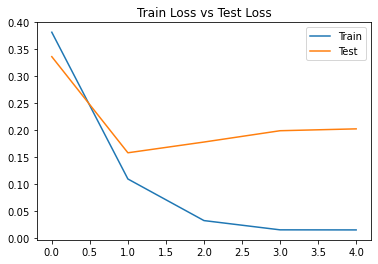

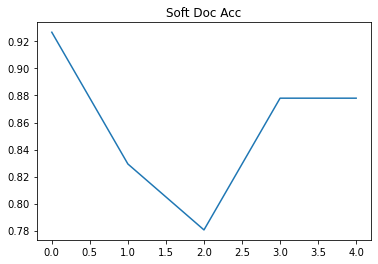

Creating vocabulary: 100%|██████████| 255/255 [00:08<00:00, 30.64it/s]


255
Found existing file, loading....
Finished loading file
Ratio: 0.5
Pos train: 126
Neg train: 129
Batch size: 18
Randomizing training and testing data..


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.encoder.layer.9.attention.self.value.bias', 'roberta.encoder.layer.11.attention.output.dense.bias', 'roberta.encoder.layer.8.attention.self.value.bias', 'roberta.encoder.layer.8.output.dense.bias', 'roberta.encoder.layer.8.attention.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.value.bias', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.9.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.output.LayerNorm.bias', 'roberta.encoder.layer.8.attention.self.query.weight', 'roberta.encoder.layer.10.intermediate.dense.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'roberta.encoder.layer.10.attention.output.dense.weight', 'roberta.encoder.layer.11.output.LayerNorm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bi



Training (0/5): {'precision': 0.8177178271965002, 'recall': 0.8796078431372549, 'f1': 0.8475344795012281, 'tp': 2243, 'tn': 1540, 'fp': 500, 'fn': 307} Loss: 0.37755

---------- EVALUATION ----------
Document Accuracy: 0.3506
Soft Document Accuracy: 1.0
Chunk Accuracy: 0.8468
Loss: 0.46652471893406533
precision: 0.2478813559322034
recall: 0.9915254237288136
f1: 0.39661016949152544
tp: 117
tn: 1851
fp: 355
fn: 1


Training Epochs:  20%|██        | 1/5 [02:43<10:52, 163.19s/it]



Training (1/5): {'precision': 0.9706342991386061, 'recall': 0.972156862745098, 'f1': 0.9713949843260189, 'tp': 2479, 'tn': 1965, 'fp': 75, 'fn': 71} Loss: 0.10266

---------- EVALUATION ----------
Document Accuracy: 0.4156
Soft Document Accuracy: 1.0
Chunk Accuracy: 0.917
Loss: 0.29603362978472336
precision: 0.3778501628664495
recall: 0.9830508474576272
f1: 0.5458823529411765
tp: 116
tn: 2015
fp: 191
fn: 2


Training Epochs:  40%|████      | 2/5 [05:27<08:12, 164.14s/it]



Training (2/5): {'precision': 0.9882168106834249, 'recall': 0.9866666666666667, 'f1': 0.9874411302982731, 'tp': 2516, 'tn': 2010, 'fp': 30, 'fn': 34} Loss: 0.04755

---------- EVALUATION ----------
Document Accuracy: 0.5584
Soft Document Accuracy: 0.9211
Chunk Accuracy: 0.9669
Loss: 0.0937532669314268
precision: 0.6184971098265896
recall: 0.9067796610169492
f1: 0.7353951890034364
tp: 107
tn: 2140
fp: 66
fn: 11


Training Epochs:  60%|██████    | 3/5 [08:13<05:29, 164.65s/it]



Training (3/5): {'precision': 0.997248427672956, 'recall': 0.9949019607843137, 'f1': 0.9960738123282293, 'tp': 2537, 'tn': 2033, 'fp': 7, 'fn': 13} Loss: 0.0152

---------- EVALUATION ----------
Document Accuracy: 0.4545
Soft Document Accuracy: 0.9211
Chunk Accuracy: 0.9475
Loss: 0.213035116472596
precision: 0.49107142857142855
recall: 0.9322033898305084
f1: 0.6432748538011696
tp: 110
tn: 2092
fp: 114
fn: 8


Training Epochs:  80%|████████  | 4/5 [10:59<02:45, 165.22s/it]



Training (4/5): {'precision': 0.9933463796477495, 'recall': 0.9952941176470588, 'f1': 0.9943192948090108, 'tp': 2538, 'tn': 2023, 'fp': 17, 'fn': 12} Loss: 0.01882

---------- EVALUATION ----------
Document Accuracy: 0.6104
Soft Document Accuracy: 0.8421
Chunk Accuracy: 0.9776
Loss: 0.09353231087889426
precision: 0.7796610169491526
recall: 0.7796610169491526
f1: 0.7796610169491526
tp: 92
tn: 2180
fp: 26
fn: 26


Training Epochs: 100%|██████████| 5/5 [13:44<00:00, 164.94s/it]

Finished Training!


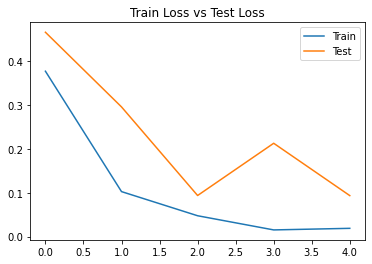

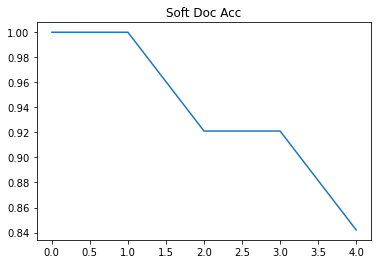

Creating vocabulary: 100%|██████████| 255/255 [00:08<00:00, 30.87it/s]


255
Found existing file, loading....
Finished loading file
Ratio: 0.7
Pos train: 195
Neg train: 60
Batch size: 18
Randomizing training and testing data..


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.encoder.layer.9.attention.self.value.bias', 'roberta.encoder.layer.11.attention.output.dense.bias', 'roberta.encoder.layer.8.attention.self.value.bias', 'roberta.encoder.layer.8.output.dense.bias', 'roberta.encoder.layer.8.attention.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.value.bias', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.9.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.output.LayerNorm.bias', 'roberta.encoder.layer.8.attention.self.query.weight', 'roberta.encoder.layer.10.intermediate.dense.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'roberta.encoder.layer.10.attention.output.dense.weight', 'roberta.encoder.layer.11.output.LayerNorm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bi



Training (0/5): {'precision': 0.859185325060696, 'recall': 0.9607843137254902, 'f1': 0.9071489604101397, 'tp': 3185, 'tn': 753, 'fp': 522, 'fn': 130} Loss: 0.31054

---------- EVALUATION ----------
Document Accuracy: 0.0779
Soft Document Accuracy: 0.9831
Chunk Accuracy: 0.878
Loss: 0.5638862404149848
precision: 0.18285714285714286
recall: 0.9696969696969697
f1: 0.3076923076923077
tp: 64
tn: 2009
fp: 286
fn: 2


Training Epochs:  20%|██        | 1/5 [02:43<10:55, 163.99s/it]



Training (1/5): {'precision': 0.9853205512282804, 'recall': 0.9921568627450981, 'f1': 0.9887268901247557, 'tp': 3289, 'tn': 1226, 'fp': 49, 'fn': 26} Loss: 0.06461

---------- EVALUATION ----------
Document Accuracy: 0.1818
Soft Document Accuracy: 0.9661
Chunk Accuracy: 0.9305
Loss: 0.42509047985197856
precision: 0.27927927927927926
recall: 0.9393939393939394
f1: 0.4305555555555555
tp: 62
tn: 2135
fp: 160
fn: 4


Training Epochs:  40%|████      | 2/5 [05:29<08:14, 164.88s/it]



Training (2/5): {'precision': 0.9936861094407697, 'recall': 0.9969834087481146, 'f1': 0.9953320283089897, 'tp': 3305, 'tn': 1254, 'fp': 21, 'fn': 10} Loss: 0.02879

---------- EVALUATION ----------
Document Accuracy: 0.1558
Soft Document Accuracy: 0.9831
Chunk Accuracy: 0.9115
Loss: 0.5375564529306509
precision: 0.23616236162361623
recall: 0.9696969696969697
f1: 0.3798219584569733
tp: 64
tn: 2088
fp: 207
fn: 2


Training Epochs:  60%|██████    | 3/5 [08:15<05:30, 165.35s/it]



Training (3/5): {'precision': 0.9942908653846154, 'recall': 0.9981900452488688, 'f1': 0.9962366400722565, 'tp': 3309, 'tn': 1256, 'fp': 19, 'fn': 6} Loss: 0.02266

---------- EVALUATION ----------
Document Accuracy: 0.2208
Soft Document Accuracy: 0.9831
Chunk Accuracy: 0.9305
Loss: 0.4920560951864758
precision: 0.28125
recall: 0.9545454545454546
f1: 0.4344827586206897
tp: 63
tn: 2134
fp: 161
fn: 3


Training Epochs:  80%|████████  | 4/5 [11:01<02:45, 165.64s/it]



Training (4/5): {'precision': 0.9960890493381468, 'recall': 0.9987933634992459, 'f1': 0.9974393733996083, 'tp': 3311, 'tn': 1262, 'fp': 13, 'fn': 4} Loss: 0.01647

---------- EVALUATION ----------
Document Accuracy: 0.2987
Soft Document Accuracy: 0.9492
Chunk Accuracy: 0.9572
Loss: 0.3760711591896395
precision: 0.3885350318471338
recall: 0.9242424242424242
f1: 0.547085201793722
tp: 61
tn: 2199
fp: 96
fn: 5


Training Epochs: 100%|██████████| 5/5 [13:47<00:00, 165.48s/it]

Finished Training!


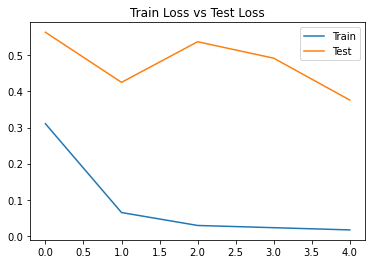

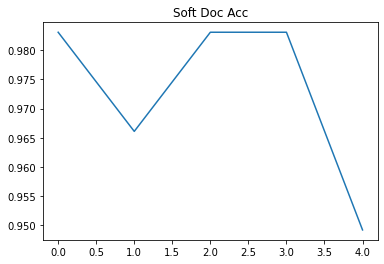

Creating vocabulary: 100%|██████████| 255/255 [00:08<00:00, 31.16it/s]


255
Found existing file, loading....
Finished loading file
Ratio: 0.4
Pos train: 110
Neg train: 145
Batch size: 19
Randomizing training and testing data..


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.encoder.layer.9.attention.self.value.bias', 'roberta.encoder.layer.11.attention.output.dense.bias', 'roberta.encoder.layer.8.attention.self.value.bias', 'roberta.encoder.layer.8.output.dense.bias', 'roberta.encoder.layer.8.attention.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.value.bias', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.9.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.output.LayerNorm.bias', 'roberta.encoder.layer.8.attention.self.query.weight', 'roberta.encoder.layer.10.intermediate.dense.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'roberta.encoder.layer.10.attention.output.dense.weight', 'roberta.encoder.layer.11.output.LayerNorm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bi



Training (0/5): {'precision': 0.8978149100257069, 'recall': 0.6848039215686275, 'f1': 0.7769744160177975, 'tp': 1397, 'tn': 2646, 'fp': 159, 'fn': 643} Loss: 0.34428

---------- EVALUATION ----------
Document Accuracy: 0.5195
Soft Document Accuracy: 0.9697
Chunk Accuracy: 0.9364
Loss: 0.15940597940647563
precision: 0.35323383084577115
recall: 0.8875
f1: 0.5053380782918149
tp: 71
tn: 1975
fp: 130
fn: 9


Training Epochs:  20%|██        | 1/5 [02:57<11:50, 177.70s/it]



Training (1/5): {'precision': 0.9797003383276945, 'recall': 0.9936274509803922, 'f1': 0.9866147481138963, 'tp': 2027, 'tn': 2763, 'fp': 42, 'fn': 13} Loss: 0.04218

---------- EVALUATION ----------
Document Accuracy: 0.5325
Soft Document Accuracy: 1.0
Chunk Accuracy: 0.9309
Loss: 0.2089735873742029
precision: 0.3422222222222222
recall: 0.9625
f1: 0.5049180327868852
tp: 77
tn: 1957
fp: 148
fn: 3


Training Epochs:  40%|████      | 2/5 [05:49<08:43, 174.49s/it]



Training (2/5): {'precision': 0.9926793557833089, 'recall': 0.9970588235294118, 'f1': 0.9948642699926633, 'tp': 2034, 'tn': 2790, 'fp': 15, 'fn': 6} Loss: 0.01635

---------- EVALUATION ----------
Document Accuracy: 0.7403
Soft Document Accuracy: 1.0
Chunk Accuracy: 0.9785
Loss: 0.08741274805869545
precision: 0.6571428571428571
recall: 0.8625
f1: 0.745945945945946
tp: 69
tn: 2069
fp: 36
fn: 11


Training Epochs:  60%|██████    | 3/5 [08:41<05:46, 173.36s/it]



Training (3/5): {'precision': 0.9951171875, 'recall': 0.9990196078431373, 'f1': 0.99706457925636, 'tp': 2038, 'tn': 2795, 'fp': 10, 'fn': 2} Loss: 0.01135

---------- EVALUATION ----------
Document Accuracy: 0.7273
Soft Document Accuracy: 1.0
Chunk Accuracy: 0.9835
Loss: 0.061859327354075316
precision: 0.7894736842105263
recall: 0.75
f1: 0.7692307692307692
tp: 60
tn: 2089
fp: 16
fn: 20


Training Epochs:  80%|████████  | 4/5 [11:33<02:52, 172.61s/it]



Training (4/5): {'precision': 0.9936492427943332, 'recall': 0.9970588235294118, 'f1': 0.9953511132860289, 'tp': 2034, 'tn': 2792, 'fp': 13, 'fn': 6} Loss: 0.01226

---------- EVALUATION ----------
Document Accuracy: 0.6364
Soft Document Accuracy: 1.0
Chunk Accuracy: 0.9689
Loss: 0.11999147610630018
precision: 0.546875
recall: 0.875
f1: 0.6730769230769231
tp: 70
tn: 2047
fp: 58
fn: 10


Training Epochs: 100%|██████████| 5/5 [14:26<00:00, 173.23s/it]

Finished Training!


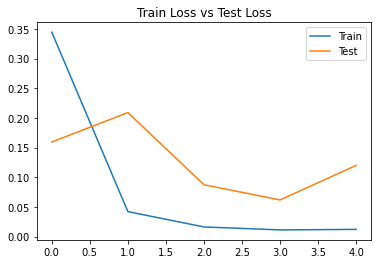

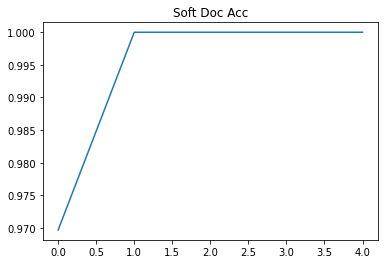

Creating vocabulary: 100%|██████████| 255/255 [00:08<00:00, 29.68it/s]


255
Found existing file, loading....
Finished loading file
Ratio: 0.4
Pos train: 98
Neg train: 157
Batch size: 19
Randomizing training and testing data..


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.encoder.layer.9.attention.self.value.bias', 'roberta.encoder.layer.11.attention.output.dense.bias', 'roberta.encoder.layer.8.attention.self.value.bias', 'roberta.encoder.layer.8.output.dense.bias', 'roberta.encoder.layer.8.attention.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.value.bias', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.9.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.output.LayerNorm.bias', 'roberta.encoder.layer.8.attention.self.query.weight', 'roberta.encoder.layer.10.intermediate.dense.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'roberta.encoder.layer.10.attention.output.dense.weight', 'roberta.encoder.layer.11.output.LayerNorm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bi



Training (0/5): {'precision': 0.867862969004894, 'recall': 0.7823529411764706, 'f1': 0.8228924980665119, 'tp': 1596, 'tn': 2562, 'fp': 243, 'fn': 444} Loss: 0.28352

---------- EVALUATION ----------
Document Accuracy: 0.4103
Soft Document Accuracy: 0.8
Chunk Accuracy: 0.9698
Loss: 0.12381866093701085
precision: 0.3170731707317073
recall: 0.6666666666666666
f1: 0.4297520661157025
tp: 26
tn: 2189
fp: 56
fn: 13


Training Epochs:  20%|██        | 1/5 [02:50<11:23, 170.97s/it]



Training (1/5): {'precision': 0.9740134744947064, 'recall': 0.9921568627450981, 'f1': 0.9830014570179699, 'tp': 2024, 'tn': 2751, 'fp': 54, 'fn': 16} Loss: 0.05563

---------- EVALUATION ----------
Document Accuracy: 0.4231
Soft Document Accuracy: 0.9333
Chunk Accuracy: 0.9641
Loss: 0.1922819804540501
precision: 0.29906542056074764
recall: 0.8205128205128205
f1: 0.4383561643835616
tp: 32
tn: 2170
fp: 75
fn: 7


Training Epochs:  40%|████      | 2/5 [05:48<08:44, 174.92s/it]



Training (2/5): {'precision': 0.9864209505334627, 'recall': 0.9970588235294118, 'f1': 0.991711360312043, 'tp': 2034, 'tn': 2777, 'fp': 28, 'fn': 6} Loss: 0.02807

---------- EVALUATION ----------
Document Accuracy: 0.4487
Soft Document Accuracy: 0.8333
Chunk Accuracy: 0.9711
Loss: 0.1732740615724395
precision: 0.3373493975903614
recall: 0.717948717948718
f1: 0.459016393442623
tp: 28
tn: 2190
fp: 55
fn: 11


Training Epochs:  60%|██████    | 3/5 [08:44<05:50, 175.35s/it]



Training (3/5): {'precision': 0.9921951219512195, 'recall': 0.9970588235294118, 'f1': 0.9946210268948655, 'tp': 2034, 'tn': 2789, 'fp': 16, 'fn': 6} Loss: 0.01945

---------- EVALUATION ----------
Document Accuracy: 0.3333
Soft Document Accuracy: 0.9667
Chunk Accuracy: 0.9492
Loss: 0.327798118634233
precision: 0.23448275862068965
recall: 0.8717948717948718
f1: 0.3695652173913043
tp: 34
tn: 2134
fp: 111
fn: 5


Training Epochs:  80%|████████  | 4/5 [11:37<02:54, 174.37s/it]



Training (4/5): {'precision': 0.99365234375, 'recall': 0.9975490196078431, 'f1': 0.9955968688845401, 'tp': 2035, 'tn': 2792, 'fp': 13, 'fn': 5} Loss: 0.01304

---------- EVALUATION ----------
Document Accuracy: 0.3077
Soft Document Accuracy: 1.0
Chunk Accuracy: 0.9391
Loss: 0.38260691623369125
precision: 0.20930232558139536
recall: 0.9230769230769231
f1: 0.3412322274881517
tp: 36
tn: 2109
fp: 136
fn: 3


Training Epochs: 100%|██████████| 5/5 [14:30<00:00, 174.05s/it]

Finished Training!


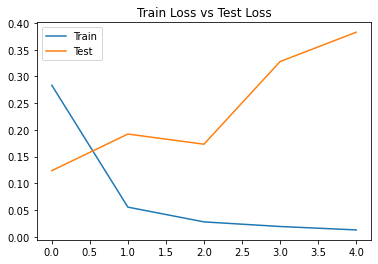

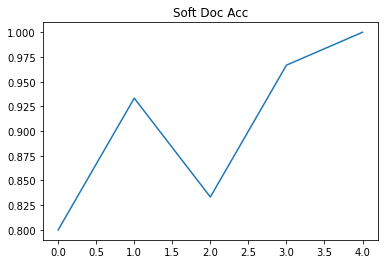

Creating vocabulary: 100%|██████████| 255/255 [00:08<00:00, 28.39it/s]


255
Found existing file, loading....
Finished loading file
Ratio: 0.3
Pos train: 86
Neg train: 169
Batch size: 19
Randomizing training and testing data..


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.encoder.layer.9.attention.self.value.bias', 'roberta.encoder.layer.11.attention.output.dense.bias', 'roberta.encoder.layer.8.attention.self.value.bias', 'roberta.encoder.layer.8.output.dense.bias', 'roberta.encoder.layer.8.attention.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.value.bias', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.9.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.output.LayerNorm.bias', 'roberta.encoder.layer.8.attention.self.query.weight', 'roberta.encoder.layer.10.intermediate.dense.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'roberta.encoder.layer.10.attention.output.dense.weight', 'roberta.encoder.layer.11.output.LayerNorm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bi



Training (0/5): {'precision': 0.8045977011494253, 'recall': 0.5032679738562091, 'f1': 0.6192199437072777, 'tp': 770, 'tn': 3128, 'fp': 187, 'fn': 760} Loss: 0.4068

---------- EVALUATION ----------
Document Accuracy: 0.4805
Soft Document Accuracy: 0.6154
Chunk Accuracy: 0.9538
Loss: 0.1519071761301005
precision: 0.4095238095238095
recall: 0.524390243902439
f1: 0.4598930481283422
tp: 43
tn: 2041
fp: 62
fn: 39


Training Epochs:  20%|██        | 1/5 [02:51<11:27, 171.84s/it]



Training (1/5): {'precision': 0.9437420986093552, 'recall': 0.9758169934640523, 'f1': 0.9595115681233932, 'tp': 1493, 'tn': 3226, 'fp': 89, 'fn': 37} Loss: 0.08541

---------- EVALUATION ----------
Document Accuracy: 0.4545
Soft Document Accuracy: 0.6923
Chunk Accuracy: 0.9497
Loss: 0.21806846579306988
precision: 0.38524590163934425
recall: 0.573170731707317
f1: 0.46078431372549017
tp: 47
tn: 2028
fp: 75
fn: 35


Training Epochs:  40%|████      | 2/5 [05:46<08:40, 173.61s/it]



Training (2/5): {'precision': 0.9781068898905344, 'recall': 0.9928104575163399, 'f1': 0.9854038274408043, 'tp': 1519, 'tn': 3281, 'fp': 34, 'fn': 11} Loss: 0.03349

---------- EVALUATION ----------
Document Accuracy: 0.5844
Soft Document Accuracy: 0.5769
Chunk Accuracy: 0.9661
Loss: 0.19901013530808948
precision: 0.5625
recall: 0.43902439024390244
f1: 0.4931506849315069
tp: 36
tn: 2075
fp: 28
fn: 46


Training Epochs:  60%|██████    | 3/5 [08:39<05:46, 173.21s/it]



Training (3/5): {'precision': 0.9837662337662337, 'recall': 0.9901960784313726, 'f1': 0.986970684039088, 'tp': 1515, 'tn': 3290, 'fp': 25, 'fn': 15} Loss: 0.02862

---------- EVALUATION ----------
Document Accuracy: 0.5195
Soft Document Accuracy: 0.6923
Chunk Accuracy: 0.9588
Loss: 0.2448221889329022
precision: 0.46153846153846156
recall: 0.5853658536585366
f1: 0.5161290322580645
tp: 48
tn: 2047
fp: 56
fn: 34


Training Epochs:  80%|████████  | 4/5 [11:32<02:53, 173.10s/it]



Training (4/5): {'precision': 0.9967362924281984, 'recall': 0.9980392156862745, 'f1': 0.9973873285434357, 'tp': 1527, 'tn': 3310, 'fp': 5, 'fn': 3} Loss: 0.00877

---------- EVALUATION ----------
Document Accuracy: 0.5584
Soft Document Accuracy: 0.4615
Chunk Accuracy: 0.9634
Loss: 0.2740696981793433
precision: 0.515625
recall: 0.4024390243902439
f1: 0.452054794520548
tp: 33
tn: 2072
fp: 31
fn: 49


Training Epochs: 100%|██████████| 5/5 [14:25<00:00, 173.12s/it]

Finished Training!


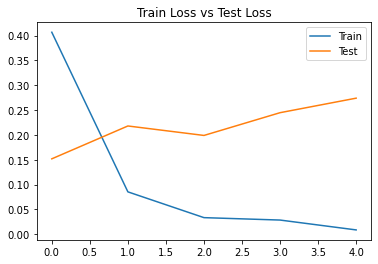

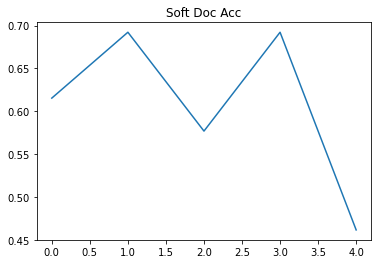

Creating vocabulary: 100%|██████████| 255/255 [00:08<00:00, 30.93it/s]


255
Found existing file, loading....
Finished loading file
Ratio: 0.3
Pos train: 88
Neg train: 167
Batch size: 18
Randomizing training and testing data..


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.encoder.layer.9.attention.self.value.bias', 'roberta.encoder.layer.11.attention.output.dense.bias', 'roberta.encoder.layer.8.attention.self.value.bias', 'roberta.encoder.layer.8.output.dense.bias', 'roberta.encoder.layer.8.attention.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.value.bias', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.9.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.output.LayerNorm.bias', 'roberta.encoder.layer.8.attention.self.query.weight', 'roberta.encoder.layer.10.intermediate.dense.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'roberta.encoder.layer.10.attention.output.dense.weight', 'roberta.encoder.layer.11.output.LayerNorm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bi



Training (0/5): {'precision': 0.9494949494949495, 'recall': 0.6143790849673203, 'f1': 0.7460317460317462, 'tp': 940, 'tn': 3010, 'fp': 50, 'fn': 590} Loss: 0.28647

---------- EVALUATION ----------
Document Accuracy: 0.5385
Soft Document Accuracy: 0.963
Chunk Accuracy: 0.9763
Loss: 0.14327055780599132
precision: 0.37209302325581395
recall: 0.9696969696969697
f1: 0.5378151260504201
tp: 32
tn: 2233
fp: 54
fn: 1


Training Epochs:  20%|██        | 1/5 [02:43<10:55, 163.91s/it]



Training (1/5): {'precision': 0.9811197916666666, 'recall': 0.984967320261438, 'f1': 0.9830397912589693, 'tp': 1507, 'tn': 3031, 'fp': 29, 'fn': 23} Loss: 0.04291

---------- EVALUATION ----------
Document Accuracy: 0.7051
Soft Document Accuracy: 0.963
Chunk Accuracy: 0.9879
Loss: 0.08036719018575521
precision: 0.5423728813559322
recall: 0.9696969696969697
f1: 0.6956521739130436
tp: 32
tn: 2260
fp: 27
fn: 1


Training Epochs:  40%|████      | 2/5 [05:30<08:16, 165.66s/it]



Training (2/5): {'precision': 0.9915639195327709, 'recall': 0.9986928104575163, 'f1': 0.995115597525236, 'tp': 1528, 'tn': 3047, 'fp': 13, 'fn': 2} Loss: 0.01722

---------- EVALUATION ----------
Document Accuracy: 0.6795
Soft Document Accuracy: 0.963
Chunk Accuracy: 0.9862
Loss: 0.07459727756661148
precision: 0.5081967213114754
recall: 0.9393939393939394
f1: 0.6595744680851064
tp: 31
tn: 2257
fp: 30
fn: 2


Training Epochs:  60%|██████    | 3/5 [08:25<05:39, 169.62s/it]



Training (3/5): {'precision': 0.9947984395318595, 'recall': 1.0, 'f1': 0.9973924380704041, 'tp': 1530, 'tn': 3052, 'fp': 8, 'fn': 0} Loss: 0.01136

---------- EVALUATION ----------
Document Accuracy: 0.7436
Soft Document Accuracy: 0.963
Chunk Accuracy: 0.9888
Loss: 0.07535466355217907
precision: 0.5636363636363636
recall: 0.9393939393939394
f1: 0.7045454545454546
tp: 31
tn: 2263
fp: 24
fn: 2


Training Epochs:  80%|████████  | 4/5 [11:25<02:53, 173.75s/it]



Training (4/5): {'precision': 0.9954456733897202, 'recall': 1.0, 'f1': 0.9977176393870232, 'tp': 1530, 'tn': 3053, 'fp': 7, 'fn': 0} Loss: 0.00938

---------- EVALUATION ----------
Document Accuracy: 0.7692
Soft Document Accuracy: 0.963
Chunk Accuracy: 0.9892
Loss: 0.05996733687397164
precision: 0.5740740740740741
recall: 0.9393939393939394
f1: 0.7126436781609197
tp: 31
tn: 2264
fp: 23
fn: 2


Training Epochs: 100%|██████████| 5/5 [14:11<00:00, 170.26s/it]

Finished Training!


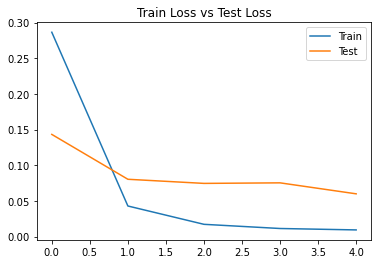

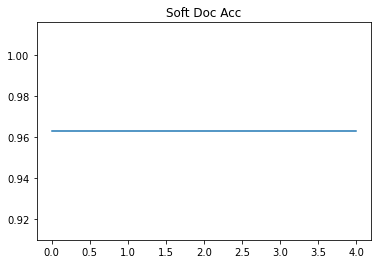

Creating vocabulary: 100%|██████████| 255/255 [00:08<00:00, 30.76it/s]


255
Found existing file, loading....
Finished loading file
Ratio: 0.3
Pos train: 86
Neg train: 169
Batch size: 18
Randomizing training and testing data..


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.encoder.layer.9.attention.self.value.bias', 'roberta.encoder.layer.11.attention.output.dense.bias', 'roberta.encoder.layer.8.attention.self.value.bias', 'roberta.encoder.layer.8.output.dense.bias', 'roberta.encoder.layer.8.attention.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.value.bias', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.9.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.output.LayerNorm.bias', 'roberta.encoder.layer.8.attention.self.query.weight', 'roberta.encoder.layer.10.intermediate.dense.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'roberta.encoder.layer.10.attention.output.dense.weight', 'roberta.encoder.layer.11.output.LayerNorm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bi



Training (0/5): {'precision': 0.9461382113821138, 'recall': 0.6084967320261437, 'f1': 0.7406523468575975, 'tp': 931, 'tn': 3007, 'fp': 53, 'fn': 599} Loss: 0.2831

---------- EVALUATION ----------
Document Accuracy: 0.6883
Soft Document Accuracy: 0.9615
Chunk Accuracy: 0.9816
Loss: 0.08410508579925283
precision: 0.4520547945205479
recall: 0.9166666666666666
f1: 0.6055045871559632
tp: 33
tn: 2256
fp: 40
fn: 3


Training Epochs:  20%|██        | 1/5 [02:50<11:22, 170.59s/it]



Training (1/5): {'precision': 0.9838292367399741, 'recall': 0.9941176470588236, 'f1': 0.9889466840052016, 'tp': 1521, 'tn': 3035, 'fp': 25, 'fn': 9} Loss: 0.02476

---------- EVALUATION ----------
Document Accuracy: 0.7792
Soft Document Accuracy: 0.9231
Chunk Accuracy: 0.9897
Loss: 0.041881662343671036
precision: 0.6153846153846154
recall: 0.8888888888888888
f1: 0.7272727272727274
tp: 32
tn: 2276
fp: 20
fn: 4


Training Epochs:  40%|████      | 2/5 [05:55<08:57, 179.26s/it]



Training (2/5): {'precision': 0.9973924380704041, 'recall': 1.0, 'f1': 0.9986945169712794, 'tp': 1530, 'tn': 3056, 'fp': 4, 'fn': 0} Loss: 0.0059

---------- EVALUATION ----------
Document Accuracy: 0.7792
Soft Document Accuracy: 0.9615
Chunk Accuracy: 0.9901
Loss: 0.05016848528205853
precision: 0.6226415094339622
recall: 0.9166666666666666
f1: 0.7415730337078651
tp: 33
tn: 2276
fp: 20
fn: 3


Training Epochs:  60%|██████    | 3/5 [09:01<06:04, 182.03s/it]



Training (3/5): {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'tp': 1530, 'tn': 3060, 'fp': 0, 'fn': 0} Loss: 0.00102

---------- EVALUATION ----------
Document Accuracy: 0.7792
Soft Document Accuracy: 0.9615
Chunk Accuracy: 0.9893
Loss: 0.06376341369733299
precision: 0.6037735849056604
recall: 0.8888888888888888
f1: 0.7191011235955056
tp: 32
tn: 2275
fp: 21
fn: 4


Training Epochs:  80%|████████  | 4/5 [11:53<02:58, 178.24s/it]



Training (4/5): {'precision': 0.9941329856584094, 'recall': 0.9967320261437909, 'f1': 0.9954308093994778, 'tp': 1525, 'tn': 3051, 'fp': 9, 'fn': 5} Loss: 0.01054

---------- EVALUATION ----------
Document Accuracy: 0.7662
Soft Document Accuracy: 0.9615
Chunk Accuracy: 0.9884
Loss: 0.05432947032499828
precision: 0.5789473684210527
recall: 0.9166666666666666
f1: 0.7096774193548387
tp: 33
tn: 2272
fp: 24
fn: 3


Training Epochs: 100%|██████████| 5/5 [14:40<00:00, 176.14s/it]

Finished Training!


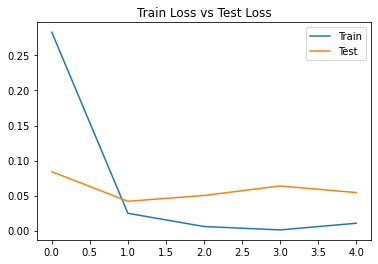

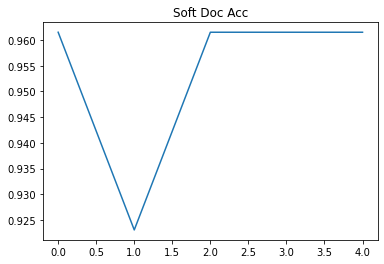

Creating vocabulary: 100%|██████████| 255/255 [00:08<00:00, 30.37it/s]


255
Found existing file, loading....
Finished loading file
Ratio: 0.3
Pos train: 76
Neg train: 179
Batch size: 20
Randomizing training and testing data..


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.encoder.layer.9.attention.self.value.bias', 'roberta.encoder.layer.11.attention.output.dense.bias', 'roberta.encoder.layer.8.attention.self.value.bias', 'roberta.encoder.layer.8.output.dense.bias', 'roberta.encoder.layer.8.attention.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.value.bias', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.9.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.output.LayerNorm.bias', 'roberta.encoder.layer.8.attention.self.query.weight', 'roberta.encoder.layer.10.intermediate.dense.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'roberta.encoder.layer.10.attention.output.dense.weight', 'roberta.encoder.layer.11.output.LayerNorm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bi



Training (0/5): {'precision': 0.8760393046107332, 'recall': 0.6492997198879552, 'f1': 0.7458172458172457, 'tp': 1159, 'tn': 3151, 'fp': 164, 'fn': 626} Loss: 0.31555

---------- EVALUATION ----------
Document Accuracy: 0.5195
Soft Document Accuracy: 0.8261
Chunk Accuracy: 0.9477
Loss: 0.14969238363109627
precision: 0.31386861313868614
recall: 0.7818181818181819
f1: 0.4479166666666667
tp: 43
tn: 1877
fp: 94
fn: 12


Training Epochs:  20%|██        | 1/5 [03:03<12:12, 183.20s/it]



Training (1/5): {'precision': 0.9820828667413214, 'recall': 0.9826330532212885, 'f1': 0.9823578829459535, 'tp': 1754, 'tn': 3283, 'fp': 32, 'fn': 31} Loss: 0.04117

---------- EVALUATION ----------
Document Accuracy: 0.7792
Soft Document Accuracy: 0.6087
Chunk Accuracy: 0.9827
Loss: 0.13936568951451933
precision: 0.7631578947368421
recall: 0.5272727272727272
f1: 0.6236559139784946
tp: 29
tn: 1962
fp: 9
fn: 26


Training Epochs:  40%|████      | 2/5 [06:08<09:13, 184.34s/it]



Training (2/5): {'precision': 0.9888579387186629, 'recall': 0.9943977591036415, 'f1': 0.9916201117318436, 'tp': 1775, 'tn': 3295, 'fp': 20, 'fn': 10} Loss: 0.0211

---------- EVALUATION ----------
Document Accuracy: 0.6883
Soft Document Accuracy: 0.8261
Chunk Accuracy: 0.9783
Loss: 0.1569679045056404
precision: 0.5753424657534246
recall: 0.7636363636363637
f1: 0.65625
tp: 42
tn: 1940
fp: 31
fn: 13


Training Epochs:  60%|██████    | 3/5 [09:12<06:08, 184.15s/it]



Training (3/5): {'precision': 0.9972067039106145, 'recall': 1.0, 'f1': 0.9986013986013986, 'tp': 1785, 'tn': 3310, 'fp': 5, 'fn': 0} Loss: 0.00611

---------- EVALUATION ----------
Document Accuracy: 0.6753
Soft Document Accuracy: 0.8261
Chunk Accuracy: 0.9793
Loss: 0.19111900679032354
precision: 0.5942028985507246
recall: 0.7454545454545455
f1: 0.661290322580645
tp: 41
tn: 1943
fp: 28
fn: 14


Training Epochs:  80%|████████  | 4/5 [12:16<03:04, 184.03s/it]



Training (4/5): {'precision': 0.996078431372549, 'recall': 0.996078431372549, 'f1': 0.996078431372549, 'tp': 1778, 'tn': 3308, 'fp': 7, 'fn': 7} Loss: 0.00957

---------- EVALUATION ----------
Document Accuracy: 0.5844
Soft Document Accuracy: 0.8696
Chunk Accuracy: 0.9733
Loss: 0.17764974181697546
precision: 0.5057471264367817
recall: 0.8
f1: 0.619718309859155
tp: 44
tn: 1928
fp: 43
fn: 11


Training Epochs: 100%|██████████| 5/5 [15:19<00:00, 183.81s/it]

Finished Training!


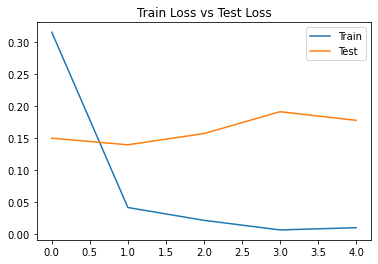

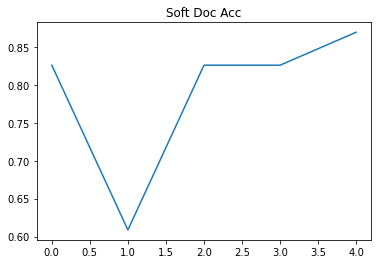

Creating vocabulary: 100%|██████████| 255/255 [00:08<00:00, 28.77it/s]


255
Found existing file, loading....
Finished loading file
Ratio: 0.2
Pos train: 40
Neg train: 215
Batch size: 19
Randomizing training and testing data..


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.encoder.layer.9.attention.self.value.bias', 'roberta.encoder.layer.11.attention.output.dense.bias', 'roberta.encoder.layer.8.attention.self.value.bias', 'roberta.encoder.layer.8.output.dense.bias', 'roberta.encoder.layer.8.attention.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.value.bias', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.11.attention.self.value.weight', 'roberta.encoder.layer.9.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.output.LayerNorm.bias', 'roberta.encoder.layer.8.attention.self.query.weight', 'roberta.encoder.layer.10.intermediate.dense.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'roberta.encoder.layer.10.attention.output.dense.weight', 'roberta.encoder.layer.11.output.LayerNorm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bi



Training (0/5): {'precision': 0.6827503015681544, 'recall': 0.5549019607843138, 'f1': 0.6122228231476474, 'tp': 566, 'tn': 3562, 'fp': 263, 'fn': 454} Loss: 0.29893

---------- EVALUATION ----------
Document Accuracy: 0.5584
Soft Document Accuracy: 0.5
Chunk Accuracy: 0.9428
Loss: 0.16980824001472106
precision: 0.08
recall: 0.5
f1: 0.13793103448275865
tp: 10
tn: 2050
fp: 115
fn: 10


Training Epochs:  20%|██        | 1/5 [02:54<11:38, 174.63s/it]



Training (1/5): {'precision': 0.9533980582524272, 'recall': 0.9627450980392157, 'f1': 0.9580487804878048, 'tp': 982, 'tn': 3777, 'fp': 48, 'fn': 38} Loss: 0.05096

---------- EVALUATION ----------
Document Accuracy: 0.7143
Soft Document Accuracy: 0.25
Chunk Accuracy: 0.9789
Loss: 0.10173513218926798
precision: 0.09375
recall: 0.15
f1: 0.11538461538461538
tp: 3
tn: 2136
fp: 29
fn: 17


Training Epochs:  40%|████      | 2/5 [05:52<08:48, 176.33s/it]



Training (2/5): {'precision': 0.9883268482490273, 'recall': 0.996078431372549, 'f1': 0.9921875, 'tp': 1016, 'tn': 3813, 'fp': 12, 'fn': 4} Loss: 0.01641

---------- EVALUATION ----------
Document Accuracy: 0.6234
Soft Document Accuracy: 0.3333
Chunk Accuracy: 0.9629
Loss: 0.15640664645909125
precision: 0.07042253521126761
recall: 0.25
f1: 0.10989010989010989
tp: 5
tn: 2099
fp: 66
fn: 15


Training Epochs:  60%|██████    | 3/5 [08:50<05:54, 177.29s/it]



Training (3/5): {'precision': 0.9883268482490273, 'recall': 0.996078431372549, 'f1': 0.9921875, 'tp': 1016, 'tn': 3813, 'fp': 12, 'fn': 4} Loss: 0.01142

---------- EVALUATION ----------
Document Accuracy: 0.7792
Soft Document Accuracy: 0.25
Chunk Accuracy: 0.9835
Loss: 0.09947420874430629
precision: 0.13636363636363635
recall: 0.15
f1: 0.14285714285714282
tp: 3
tn: 2146
fp: 19
fn: 17


Training Epochs:  80%|████████  | 4/5 [11:48<02:57, 177.35s/it]



Training (4/5): {'precision': 0.9921951219512195, 'recall': 0.9970588235294118, 'f1': 0.9946210268948655, 'tp': 1017, 'tn': 3817, 'fp': 8, 'fn': 3} Loss: 0.00911

---------- EVALUATION ----------
Document Accuracy: 0.7662
Soft Document Accuracy: 0.25
Chunk Accuracy: 0.9803
Loss: 0.11840705619879255
precision: 0.12903225806451613
recall: 0.2
f1: 0.1568627450980392
tp: 4
tn: 2138
fp: 27
fn: 16


Training Epochs: 100%|██████████| 5/5 [14:43<00:00, 176.61s/it]

Finished Training!


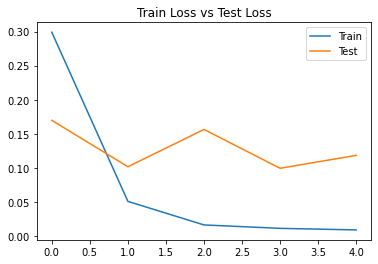

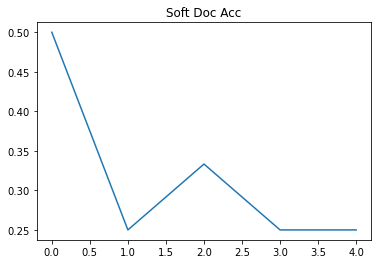

In [10]:
categories = ["expiration_date", "anti-assignment", "cap_on_liability", "license_grant", "effective_date", "audit_rights", "termination_for_convenience"]
categories_2 = ["exclusivity", "renewal_term", "insurance", "revenueprofit_sharing", "volume_restriction"]

categories = categories + categories_2

model_name = "roberta-base"

run_with_categories(categories, model_name)